# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [8]:
import pandas as pd
import numpy as np
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [9]:
# Define here our sound analysis function
# NOTE: remember that if you update this function and want to run a new analysis you'll need to re-run both 
# this cell and the cells below that carry out the audio analysis and that call the analysis function. 
# After analyzing the source collection or the target file, make sure to correct descriptors have been 
# extracted by checking the DataFrame contents. DataFrame contents can be printed on screen as a table 
# using 'display(data_frame_object)'

def analyze_sound(audio_path, frame_size= None, audio_id= None):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    
    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    
    # Some processing of frame_size parameter to avoid later problems
    if frame_size is None:
        frame_size = len(audio)  # If no frame_size is given use no frames (analyze all audio at once)
    if frame_size % 2 != 0:
        frame_size = frame_size + 1 # Make frame size even
    
    # Calculate the start and end samples for each equally-spaced audio frame
    frame_start_samples = range(0, len(audio), frame_size)
    frame_start_end_samples = zip(frame_start_samples[:-1], frame_start_samples[1:])
    
    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(frame_start_end_samples):
        
        # Get corresponding audio chunk and initialize dictionary to sotre analysis results with some basic metadata
        frame = audio[fstart:fend]
        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract MFCC coefficients
        w_algo = estd.Windowing(type = 'hann')
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        
        # Extract other features here and add to 'frame_output' dictionary
        
        # extracting tonality using essentia
        key_algo = estd.KeyExtractor()
        key, scale, key_strength = key_algo(audio)
        frame_output['tonality']= key
        frame_output['scale']= scale
        frame_output['strength']= key_strength
        # ...
        
        # Add frame analysis results to output
        analysis_output.append(frame_output)

    return analysis_output
   

## Analyze source collection

In [10]:
DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source.csv'  # DataFrame file where to store the results of our analysis

# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    analysis_output = analyze_sound(sound['path'], frame_size=8192, audio_id=sound['freesound_id'])  # Split audio in chunks of 200ms (44100/5 samples)
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 384671 [1/50]
Analyzing sound with id 459895 [2/50]
Analyzing sound with id 118524 [3/50]
Analyzing sound with id 400707 [4/50]
Analyzing sound with id 269716 [5/50]
Analyzing sound with id 270276 [6/50]
Analyzing sound with id 318331 [7/50]
Analyzing sound with id 198104 [8/50]
Analyzing sound with id 410149 [9/50]
Analyzing sound with id 469656 [10/50]
Analyzing sound with id 340468 [11/50]
Analyzing sound with id 194021 [12/50]
Analyzing sound with id 445070 [13/50]
Analyzing sound with id 41355 [14/50]
Analyzing sound with id 82247 [15/50]
Analyzing sound with id 414680 [16/50]
Analyzing sound with id 375287 [17/50]
Analyzing sound with id 100789 [18/50]
Analyzing sound with id 71377 [19/50]
Analyzing sound with id 347130 [20/50]
Analyzing sound with id 145634 [21/50]
Analyzing sound with id 342701 [22/50]
Analyzing sound with id 254690 [23/50]
Analyzing sound with id 45420 [24/50]
Analyzing sound with id 299847 [25/50]
Analyzing sound with id 300819 [26/50]

,end_sample,freesound_id,id,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,start_sample,strength,tonality
0,8192,384671,384671_f0,7.442987e-04,-816.349365,146.160263,-7.331871,-7.202431,-2.744911,19.301338,...,1.129326,-12.288769,-1.930347,-4.834192,-6.147079,files/384671_5591103-hq.ogg,major,0,0.400469,D
1,8192,459895,459895_f0,1.190373e-02,-1032.168945,143.977844,8.466816,3.867470,-0.834511,126.675232,...,53.424988,35.939552,24.418528,17.410381,12.709223,files/459895_4448255-hq.ogg,minor,0,0.664666,G
2,16384,459895,459895_f1,2.130826e-03,-1098.788330,55.761086,32.251736,28.360277,24.474464,54.907139,...,49.197388,46.386192,43.216026,39.754818,36.075035,files/459895_4448255-hq.ogg,minor,8192,0.664666,G
3,24576,459895,459895_f2,1.570613e-03,-1101.163086,52.435314,31.465740,27.957850,24.440086,51.678745,...,46.611542,44.110924,41.285870,38.194698,34.899773,files/459895_4448255-hq.ogg,minor,16384,0.664666,G
4,32768,459895,459895_f3,1.582594e-03,-1101.626953,51.792370,31.741482,28.349482,24.932999,51.074253,...,46.255585,43.871559,41.172955,38.213177,35.049492,files/459895_4448255-hq.ogg,minor,24576,0.664666,G
5,8192,118524,118524_f0,5.644164e-03,-728.640930,178.094101,9.244968,7.820652,2.472843,3.148888,...,22.733047,16.819622,21.189894,16.507545,14.948086,files/118524_1753199-hq.ogg,minor,0,0.721619,D
6,16384,118524,118524_f1,4.520879e-03,-984.603699,178.181183,16.198223,7.199593,2.052628,96.846313,...,31.975769,31.017220,25.302744,23.737011,22.783945,files/118524_1753199-hq.ogg,minor,8192,0.721619,D
7,24576,118524,118524_f2,5.631998e-04,-1034.092041,125.972145,13.084393,9.456604,4.696053,78.013733,...,21.806183,24.145817,20.962854,16.479809,14.494242,files/118524_1753199-hq.ogg,minor,16384,0.721619,D
8,32768,118524,118524_f3,4.940587e-05,-1079.778076,76.580360,7.418003,4.178169,1.490341,60.427097,...,17.712631,15.018559,14.565126,13.465336,10.843790,files/118524_1753199-hq.ogg,minor,24576,0.721619,D
9,8192,400707,400707_f0,1.641828e-02,-1013.777405,162.633942,11.561642,8.764923,7.650673,128.414185,...,42.454407,35.823921,31.399759,24.978786,17.391932,files/400707_1126957-hq.ogg,minor,0,0.451639,Eb


,end_sample,freesound_id,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,start_sample,strength
count,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000
mean,254498.455726,258269.642267,0.002531,-893.587360,150.935265,-4.916278,-4.162695,-6.096284,39.323547,13.711900,0.938878,-1.302077,-4.900232,-2.378288,-3.604408,-3.879017,246306.455726,0.833594
std,164200.508903,96237.224217,0.003450,135.970952,77.523828,10.007222,9.004326,8.894292,51.582322,34.567163,27.373301,20.455100,15.970103,13.810571,12.873622,10.969090,164200.508903,0.055822
min,8192.000000,7884.000000,0.000000,-1138.420044,-185.677505,-49.692589,-47.992146,-42.404629,-77.515915,-69.026283,-86.107109,-49.258511,-45.912300,-44.978546,-57.115395,-43.826523,0.000000,0.224274
25%,114688.000000,280898.000000,0.000308,-987.675171,99.114529,-11.891875,-11.192112,-12.131453,1.191781,-8.254591,-15.582266,-15.476013,-15.720668,-8.276775,-10.370448,-10.232100,106496.000000,0.832885
50%,237568.000000,300819.000000,0.000967,-887.334778,142.400108,-5.644152,-3.725554,-6.547853,23.895937,9.410662,-1.856431,0.000023,-6.058292,-1.856195,-3.313950,-4.243901,229376.000000,0.841686
75%,385024.000000,304530.000000,0.003139,-791.441620,209.276192,0.704580,1.102411,-0.004299,81.720871,28.470975,14.706245,10.262051,4.605494,5.169448,3.833735,2.655594,376832.000000,0.860273
max,655360.000000,469656.000000,0.019192,-518.369751,322.143524,35.044872,29.527666,24.932999,157.015625,102.447067,80.846954,65.966499,60.015709,53.707504,47.297230,41.013748,647168.000000,0.882919


## Analyze the target sound file

In [11]:
features, features_frames = estd.MusicExtractor(lowlevelStats=['mean', 'stdev'],
                                              rhythmStats=['mean', 'stdev'],
                                              tonalStats=['mean', 'stdev'])('prowhite.wav')


Extracting the Pitch and BPM and trying to add them to the frame_output

In [12]:
#check BPM 
print("BPM:", features['rhythm.bpm'])


BPM: 92.88431549072266


Analyzing target sound prowhite.wav
Saved target dataframe with 272 entries! dataframe_target.csv


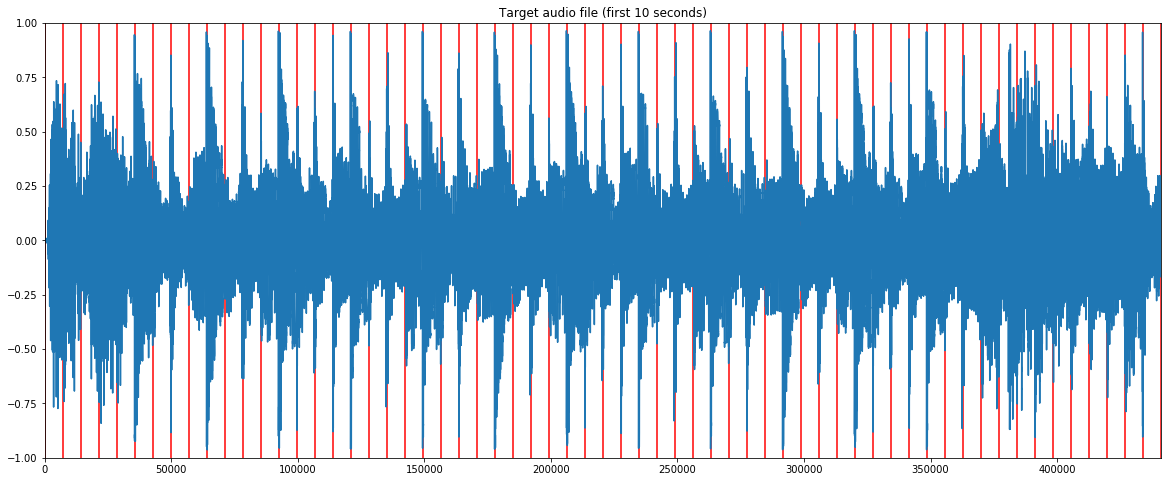

,end_sample,freesound_id,id,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,start_sample,strength,tonality
0,7112,None,None_f0,0.006638,-575.815002,102.284744,-13.485485,7.700674,1.507954,-24.382818,...,-16.157393,-45.453003,-21.055023,-21.527166,-23.783484,prowhite.wav,major,0,0.880048,A
1,14224,None,None_f1,0.006968,-617.654236,113.091370,-13.609159,0.570915,0.381073,8.550501,...,-12.372835,-36.406151,-20.985359,-25.492361,-14.889763,prowhite.wav,major,7112,0.880048,A
2,21336,None,None_f2,0.006324,-638.946289,124.718391,3.157146,15.091774,4.261984,32.828888,...,-13.290321,-23.514261,-10.825630,-18.253376,-17.748070,prowhite.wav,major,14224,0.880048,A
3,28448,None,None_f3,0.007757,-603.186707,123.704468,-7.069447,7.479931,-2.250017,11.751976,...,-24.996304,-12.965811,6.379320,-16.460052,-22.945707,prowhite.wav,major,21336,0.880048,A
4,35560,None,None_f4,0.005773,-638.696350,148.116943,0.170391,4.045820,-0.401028,8.275211,...,-4.426888,-6.110743,19.606201,-10.139559,-13.717506,prowhite.wav,major,28448,0.880048,A
5,42672,None,None_f5,0.012960,-718.416931,188.067169,17.800648,17.823473,13.601948,12.343758,...,10.796833,17.985153,44.331024,17.609020,14.692017,prowhite.wav,major,35560,0.880048,A
6,49784,None,None_f6,0.002974,-758.496094,196.395874,-7.211014,3.285683,-0.985569,11.788979,...,6.686947,-4.471996,13.553970,-4.837963,-14.952435,prowhite.wav,major,42672,0.880048,A
7,56896,None,None_f7,0.003429,-684.560791,113.838165,-22.126751,4.465858,-6.357670,-11.340797,...,-4.089821,-11.424276,4.617554,1.064800,-28.599434,prowhite.wav,major,49784,0.880048,A
8,64008,None,None_f8,0.005860,-778.781433,220.061676,-4.770031,14.763819,9.504517,29.825459,...,16.221451,9.981766,11.310596,6.467327,-20.630718,prowhite.wav,major,56896,0.880048,A
9,71120,None,None_f9,0.011964,-733.912170,156.662231,7.501259,9.094330,18.449383,-4.324818,...,28.033054,28.505730,34.766506,17.942478,-6.220253,prowhite.wav,major,64008,0.880048,A


,end_sample,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,start_sample,strength
count,2.720000e+02,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,2.720000e+02,272.000000
mean,9.707880e+05,0.006912,-699.182253,117.109951,-7.099626,1.953801,3.788118,37.921024,46.015327,4.133865,1.948701,-1.256968,3.530297,0.830839,-6.853855,9.636760e+05,0.880048
std,5.594572e+05,0.003771,120.577351,36.389118,11.756014,11.442212,10.347762,30.591430,37.461188,19.090015,12.061778,12.369839,12.767659,11.965012,11.465059,5.594572e+05,0.000000
min,7.112000e+03,0.000003,-1119.287842,23.751892,-42.385414,-24.079399,-23.043358,-30.957359,-43.052422,-58.745396,-28.005190,-45.453003,-35.435989,-31.824759,-36.269642,0.000000e+00,0.880048
25%,4.889500e+05,0.004621,-747.981339,101.296516,-14.646276,-5.570054,-2.290441,18.092497,21.782279,-9.824465,-6.603089,-10.222959,-5.485938,-7.237337,-14.893185,4.818380e+05,0.880048
50%,9.707880e+05,0.005911,-668.807434,115.930840,-5.794800,1.448454,3.278692,33.090099,41.724133,4.608145,2.037091,-1.549029,3.032225,0.432635,-7.773870,9.636760e+05,0.880048
75%,1.452626e+06,0.008923,-619.470306,133.033875,0.868335,9.220830,11.003193,52.548082,72.179363,16.397268,10.209699,6.240303,10.957654,8.471839,0.006497,1.445514e+06,0.880048
max,1.934464e+06,0.014844,-530.147278,232.950729,18.932491,36.011959,31.148998,135.434677,140.295593,53.019131,29.282814,34.517700,44.331024,39.133121,32.036903,1.927352e+06,0.880048


In [13]:
TARGET_SOUND_PATH = 'prowhite.wav'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))
target_analysis = analyze_sound(TARGET_SOUND_PATH, frame_size=7111)  # Also split audio in chunks of 100ms (44100/10 samples) 
df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))

# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(20,8))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
plt.axis([0, min(len(audio), 44100 * 10), -1, 1])
plt.title('Target audio file (first 10 seconds)')
plt.show()

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame